In [1]:
import os

import tensorflow as tf
import matplotlib.pyplot as plt

os.environ['OMP_NUM_THREADS'] = '1'
tf.__version__

'2.8.0'

## Visualizing the Dataset

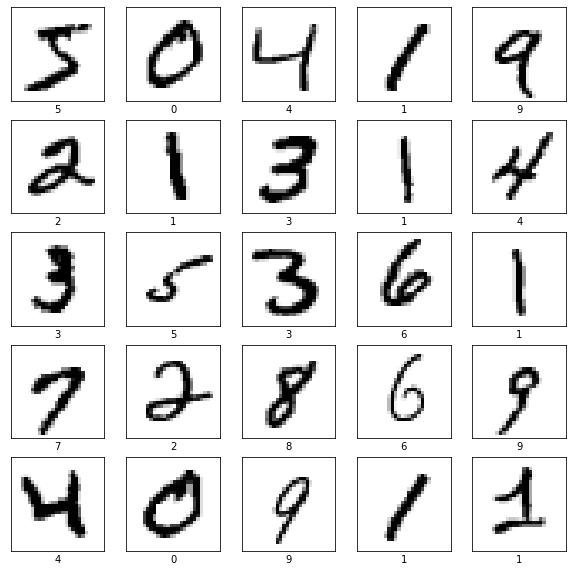

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']

#tf.cast(train_images, tf.float32)
#tf.cast(train_labels, tf.float32)
#tf.cast(test_images, tf.float32)
#tf.cast(test_labels, tf.float32)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Building the CNN

In [3]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras import layers

### First Convolutional Layer

We can now implement our first layer. The convolution will compute 32 features for each 3x3 patch. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels.

### Max Pooling Layer 

We stack max pooling layer after the first convolutional layer. These pooling layers will perform max pooling for each 2x2 patch.

### Second Convolutional Layer

In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 3x3 patch.

### Fully Connected Layers

Now that the image size has been reduced to 11x11, we add a fully-connected layer with 128 neurons to allow processing on the entire image. We reshape the tensor from the second convolutional layer into a batch of vectors before the fully connected layer. The output layer should also be implemented via a fully connect layer.

### Dropout Layer
Adding dropouts during training before each fully connected layers, as this helps avoid overfitting during training.

### Completing the Computation Graph

To apply the layer, we first reshape the input to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels (which is 1).

We then convolve the reshaped input with the first convolutional layer and then the max pooling followed by the second convolutional layer. These convolutional layers and the pooling layer will reduce the image size to 11x11.



In [5]:
class CustomizedCNN(tf.keras.models.Model):

    def __init__(self, *args, **kwargs):
        super(CustomizedCNN, self).__init__()
        self.conv_1 = layers.Conv2D(32, (3, 3,), activation='relu', input_shape=(28, 28, 1))
        self.maxpool = layers.MaxPooling2D((2,2))
        self.conv_2 = layers.Conv2D(64, (3, 3), activation='relu')
        self.flatten = layers.Flatten()
        self.dropout_1 = layers.Dropout(0.5)
        self.dense = layers.Dense(128, activation='relu')
        self.dropout_2 = layers.Dropout(0.5)
        self.classifier = layers.Dense(10, activation='relu')
        

    def call(self, inputs, training=None, mask=None):
        inputs = tf.reshape(inputs, [-1, 28, 28, 1])
        inputs = tf.cast(inputs, tf.float32)
        x = self.conv_1(inputs)
        x = self.maxpool(x)
        x = self.conv_2(x)
        x = self.flatten(x)
        x = self.dropout_1(x)
        x = self.dense(x)
        x = self.dropout_2(x)
        return self.classifier(x)

## Build the Model

In [6]:
model = CustomizedCNN()
model.build(input_shape=(None, 28, 28))
model.build(input_shape=(28, 28, 1))
model.summary()

Model: "customized_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  320       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  991360    
                                                    

### Loss Function

We can specify a loss function just as easily. Loss indicates how bad the model's prediction was on a single example; we try to minimize that while training across all the examples. Here, our loss function is the cross-entropy between the target and the softmax activation function applied to the model's prediction. As in the beginners tutorial, we use the stable formulation:

In [7]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

We will use a more sophisticated ADAM optimizer instead of a Gradient Descent Optimizer.

## Train and Evaluate the Model

In [8]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels)) 

Epoch 1/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.7426 - accuracy: 0.7772 - val_loss: 0.0895 - val_accuracy: 0.9725
Epoch 2/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.1667 - accuracy: 0.9538 - val_loss: 0.0829 - val_accuracy: 0.9760
Epoch 3/10
1875/1875 [==============================] - 59s 31ms/step - loss: 0.1390 - accuracy: 0.9606 - val_loss: 0.0572 - val_accuracy: 0.9839
Epoch 4/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.1247 - accuracy: 0.9650 - val_loss: 0.0544 - val_accuracy: 0.9843
Epoch 5/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.1125 - accuracy: 0.9689 - val_loss: 0.0474 - val_accuracy: 0.9864
Epoch 6/10
1875/1875 [==============================] - 48s 26ms/step - loss: 0.1071 - accuracy: 0.9707 - val_loss: 0.0442 - val_accuracy: 0.9854
Epoch 7/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0974 - accuracy: 0.9726 - val_loss: 0.0466 -

### Plotting Accuracy and Validation accuracy

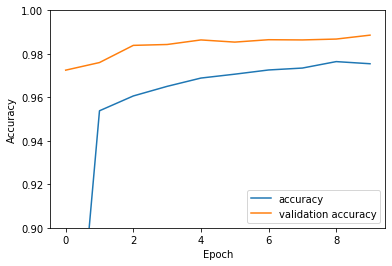

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

### Model Accuracy:

In [10]:
test_loss, test_acc = model.evaluate(test_images,  test_labels)
print(test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 0.0406 - accuracy: 0.9886
0.9886000156402588
